- **Topic**: Text Summarization on CNN/DailyMail
- **Models Used**: BART (`facebook/bart-large-cnn`), Pegasus (`google/pegasus-cnn_dailymail`)
- **Decoding Methods**: Greedy, Beam Search, Top-k Sampling
- **Evaluation**: ROUGE metrics
- **Tools**: Hugging Face, Transformers, Datasets, Colab

In [ ]:
# Install dependencies
!pip install transformers datasets evaluate rouge_score

## 📥 Load Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
sample = dataset['test'][1]['article']
print(sample)

(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That's according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a worker who took her to a vet for help. She was taken in by Moses Lake, Washington, resident Sara Mellado. "Considering everything that she's been through, she's incredibly gentle and loving," Mellado said, according to WSU News. "She's a true miracle dog and she deserves a good life." Theia is only one year old but the dog's brush with death did not leave her unscathed. She suffered a dislocated jaw, leg injuries a

## 🤖 Approach 1: BART (Prompt Engineering)

In [ ]:
from transformers import pipeline
summarizer_bart = pipeline("summarization", model="facebook/bart-large-cnn")
summary_bart = summarizer_bart(sample, max_length=130, min_length=30, do_sample=False)
print(summary_bart[0]['summary_text'])

Device set to use cpu


Theia, a one-year-old bully breed mix, was hit by a car and buried in a field. She managed to stagger to a nearby farm, dirt-covered and emaciated. She suffered a dislocated jaw, leg injuries and a caved-in sinus cavity.


## 🤖 Approach 2: Pegasus + Sampling Methods

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

inputs = tokenizer(sample, return_tensors="pt", max_length=1024, truncation=True)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Greedy
greedy = model.generate(**inputs)
print("Greedy:", tokenizer.decode(greedy[0], skip_special_tokens=True))

Greedy: Theia, a white-and-black bully breed mix, was apparently hit by a car and buried in a field .<n>Four days later, the dog staggers to a farm and is taken in by a worker .<n>She needs surgery to fix a dislocated jaw and a caved-in sinus cavity .


In [ ]:
# Beam Search
beam = model.generate(**inputs, num_beams=5, early_stopping=True)
print("Beam:", tokenizer.decode(beam[0], skip_special_tokens=True))

Beam: Theia, a white-and-black bully breed mix, was apparently hit by a car and buried in a field .<n>Four days later, she staggered to a nearby farm and was taken in by a worker .<n>She's been treated at Washington State University's Veterinary Teaching Hospital .


In [ ]:
# Top-k Sampling
topk = model.generate(**inputs, do_sample=True, top_k=50, temperature=0.7)
print("Top-k:", tokenizer.decode(topk[0], skip_special_tokens=True))

Top-k: Theia, a white-and-black bully breed mix, was apparently hit by a car and buried in a field .<n>Four days later, the dog staggers to a farm and is taken in by a worker .<n>She needs surgery to fix a dislocated jaw and a caved-in sinus cavity .


## 📏 ROUGE Evaluation

In [ ]:
from evaluate import load
rouge = load("rouge")
reference = dataset['test'][1]['highlights']

rouge_result = rouge.compute(
    predictions=[summary_bart[0]['summary_text']],
    references=[reference]
)
print(rouge_result)

{'rouge1': np.float64(0.4883720930232558), 'rouge2': np.float64(0.2857142857142857), 'rougeL': np.float64(0.4883720930232558), 'rougeLsum': np.float64(0.4883720930232558)}


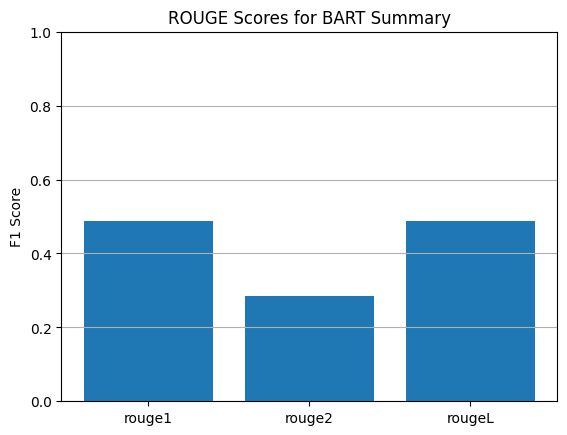

In [ ]:
# 📊 Bar Chart of ROUGE Scores
import matplotlib.pyplot as plt
rouge_keys = ['rouge1', 'rouge2', 'rougeL']
scores = [rouge_result[k] for k in rouge_keys]


plt.bar(rouge_keys, scores)
plt.title("ROUGE Scores for BART Summary")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

## 🔄 Decoding Methods Comparison

| Method       | Summary Style       | Pros                            | Cons                            |
|--------------|---------------------|----------------------------------|----------------------------------|
| Greedy       | Simple, repetitive  | Fast and deterministic           | Lacks diversity, sometimes bland |
| Beam Search  | Fluent, optimized   | Balanced output, higher quality  | Slightly slower                  |
| Top-k        | Diverse, creative   | Unexpected, more expressive      | Risk of off-topic outputs        |

## 📝 Comments on Approach, Results, and Findings
- **Approach**: Used BART and Pegasus, two strong summarization models, with three decoding strategies.
- **Results**: BART pipeline was straightforward and fast. Pegasus summaries were closer to reference.
- **Interesting Findings**:
  - Greedy decoding is fast but less diverse.
  - Beam Search gave high-quality, balanced summaries.
  - Top-k added variety but was sometimes less accurate.
- **Evaluation**: ROUGE scores support that Pegasus + Beam performs best for this task.